# Term Deposit Marketing - An Apziva Project

# EDA

By Samuel Alter

Apziva: G3SuQYZYrFt9dwF3

## Project Overview

Using phone call data from a European bank, this project will be building a model that predicts if a customer will subscribe to a term deposit, a type of financial product. This project is a partnership with a startup focused on providing ML solutions for European banks.

### Goals

The startup is hoping that I can **achieve ≥81% accuracy** using a 5-fold cross validation strategy, taking the average performance score.

Bonus goals include:
* Determining which customers are most likely to buy the term deposit loan
  * Which segments of customers should the client prioritize?
* Determine what makes the customer buy the loan
  * Which feature should the startup focus on?

### The dataset

Using phone call data from a European bank, this project will be building models that predict if a customer will subscribe to a term deposit, a type of financial product. This project is a partnership with a startup focused on providing ML solutions for European banks.

The dataset consists of the following columns:
* `age`
  * Numeric
  * The age of the customer
* `job`
  * Categorical
  * The job category of the customer
* `marital`
  * Categorical
  * Whether the customer is married
* `education`
  * Categorical
  * The customer's level of education
* `default`
  * Binary
  * If the customer has credit in default or not
* `balance`
  * Numeric
  * Average yearly balance in Euros
* `housing`
  * Binary
  * If the customer has a housing loan or not
* `loan`
  * Binary
  * If the customer has a personal loan
* `contact`
  * Categorical
  * The type of contact communication
* `day`
  * Numeric
  * Last contact day of the month
* `month`
  * Categorical
  * Last contact month of the year
* `duration`
  * Numeric
  * Duration of the last phone call with the customer
* `campaign`
  * Numeric
  * The number of contacts performed during this campaign and for this client, which includes the last contact

The final column, `y`, is the target of the dataset and shows whether the client subscribed to a term deposit.

## Imports and Helper Functions

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import joblib
import time
import threading
from datetime import datetime
# from contextlib import contextmanager
from timeit import default_timer

from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split
# from pycaret.classification import setup,compare_models,create_model,plot_model,evaluate_model
# from pycaret.regression import *

# from autosklearn.classification import AutoSklearnClassifier
import optuna

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
# import sklearn.lda.LDA as LDA # <-- this is throwing the ModuleNotFoundError

In [31]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [32]:
# simple function to generate random integers

def rand_gen(low=1,high=1e4):
    '''
    Generates a pseudo-random integer
    consisting of up to four digits
    '''
    import numpy as np
    rng=np.random.default_rng()
    random_state=int(rng.integers(low=low,high=high))
    
    return random_state

In [33]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    SOURCE: https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py

    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html

    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)

    if title:
        plt.title(title)

In [34]:
seed=rand_gen()
seed

4384

In [35]:
test_size=0.2
test_size

0.2

In [36]:
# set the randomness seed throughout the notebook
# source: # https://odsc.medium.com/properly-setting-the-random-seed-in-ml-experiments-not-as-simple-as-you-might-imagine-219969c84752

## set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed)
## set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed)
## set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed)
np.random.default_rng(seed)

Generator(PCG64) at 0x1348EE040

In [37]:
import json
from pathlib import Path
import inspect

def get_variable_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [name for name, val in callers_local_vars if val is var]

def fileDaterSaver(location: str,
                   filetype: str,
                   object_,
                   extra: str = '',
                   verbose: bool = True):

    '''
    Function that gets a timestamped filename and saves it
    to a user-specified location.

    Parameters:
    -----------
    location: str - The location where the file will be saved.
    filetype: str - The type of the file to save ('csv' or 'json').
    object_: The object to be saved. Should be a pandas DataFrame
        for 'csv' or serializable for 'json'.
    extra: str - Additional string to include in the filename.
    verbose: bool - Whether to print verbose messages.
    '''

    # get current date and time
    current_datetime = datetime.now()

    # print current date and time to check
    if verbose:
        print('current_datetime:', current_datetime)

    # format the datetime for a filename
    datetime_suffix = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

    # create filename with the datetime suffix
    if extra != '':
        file_name = f'{location}{extra}_{datetime_suffix}.{filetype}'
    else:
        file_name = f'{location}{datetime_suffix}.{filetype}'

    # print file name
    if verbose:
        print(file_name)

    # save object
    if filetype == 'csv':
        object_.to_csv(file_name, index=True)
    elif filetype == 'json':
        with open(file_name, 'w') as file:
            file.write(json.dumps(object_, default=str))
    else:
        raise ValueError("Unsupported file type. Use 'csv' or 'json'.")

    # confirm save
    file_path = Path(file_name)
    if file_path.exists():
        variable_name = get_variable_name(object_)
        if variable_name:
            print(f'Successfully saved {variable_name[0]} to {file_path}')
        else:
            print(f'Successfully saved object to {file_path}')
    else:
        print("File save error.")

In [38]:
# read in data
df=pd.read_csv('../data/2_data.csv')
df.head(3)

age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   

   contact  day month  duration  campaign   y  
0  unknown    5   may       261         1  no  
1  unknown    5   may       151         1  no  
2  unknown    5   may        76         1  no

## EDA <a name='eda'></a>

### Non-visual data analysis <a name='neda'></a>

In [39]:
print(f"There are {df.shape[0]} rows and {df.shape[1]} columns in the dataset")

There are 40000 rows and 14 columns in the dataset


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


There are no nulls in the dataset, which makes our lives easier.

In [41]:
df.describe()

age        balance           day      duration      campaign
count  40000.000000   40000.000000  40000.000000  40000.000000  40000.000000
mean      40.544600    1274.277550     16.017225    254.824300      2.882175
std        9.641776    2903.769716      8.278127    259.366498      3.239051
min       19.000000   -8019.000000      1.000000      0.000000      1.000000
25%       33.000000      54.000000      8.000000    100.000000      1.000000
50%       39.000000     407.000000     17.000000    175.000000      2.000000
75%       48.000000    1319.000000     21.000000    313.000000      3.000000
max       95.000000  102127.000000     31.000000   4918.000000     63.000000

We can glean the following insights from this table:
* The mean values for the `age`, `day`, and `campaign` columns are about equal to the 50th percentile
  * The distribution of the data may be symmetric
* The max value in each column besides `age` and `day` is much larger than the column's 75th percentile
  * This suggests there could be outliers
  * `age` and `day` are more or less categorical, so it makes sense that the max age is 95 and max day is 31

What if we compare the subset of the data that had a positive `y` outcome to those that had a negative outcome?

In [42]:
# customers in the dataset who did get a loan
df_yes = df[df['y'] == 'yes']
df_yes.describe()

age       balance          day     duration     campaign
count  2896.000000   2896.000000  2896.000000  2896.000000  2896.000000
mean     39.844959   1588.495856    15.827003   682.958564     2.414365
std      11.001984   2924.894429     8.557604   431.287174     2.306015
min      19.000000  -3058.000000     1.000000     8.000000     1.000000
25%      31.000000    141.000000     8.000000   364.000000     1.000000
50%      37.000000    620.000000    16.000000   629.000000     2.000000
75%      47.000000   1820.500000    22.000000   913.000000     3.000000
max      95.000000  45248.000000    31.000000  3881.000000    32.000000

In [43]:
# customers in the dataset who did not get a loan
df_no = df[df['y'] == 'no']
df_no.describe()

age        balance           day      duration      campaign
count  37104.000000   37104.000000  37104.000000  37104.000000  37104.000000
mean      40.599208    1249.752533     16.032072    221.408042      2.918688
std        9.525450    2900.722436      8.255850    206.360022      3.298031
min       19.000000   -8019.000000      1.000000      0.000000      1.000000
25%       33.000000      50.000000      8.000000     95.000000      1.000000
50%       39.000000     395.000000     17.000000    164.000000      2.000000
75%       48.000000    1286.000000     21.000000    280.000000      3.000000
max       94.000000  102127.000000     31.000000   4918.000000     63.000000

In [44]:
print(f"{df_yes.shape[0]/df.shape[0]*100}% of the customers received loans, while {round(df_no.shape[0]/df.shape[0]*100,2)}% of the customers did not receive loans.")

7.24% of the customers received loans, while 92.76% of the customers did not receive loans.


We can see:
* There is a large class imbalance in the dataset
* The mean values are roughly the same across the numerical columns and loan outcomes
  * Except for duration, which is about 3x as less for calls that don't end with a sale (`y`=no)
* The max values for `balance` and `campaign` are about 2.25x and 2x as large for `y`=no

Let's do some more aggregations to tease apart the differences between the different classes within each column.

In [45]:
# functions to compute the quantiles

def q25(x):
    return x.quantile(0.25)

def q50(x):
    return x.quantile(0.50)

def q75(x):
    return x.quantile(0.75)

def iqr(x):
    return q75(x)-q25(x)

We can edit this code to slice and dice the dataset as we please:

In [46]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'y'],
      dtype='object')

In [47]:
groupby_list=['count','mean','std','min',q25,q50,q75,iqr]
df.groupby([
    # 'age',
    'job',
    # 'marital',
    # 'education',
    # 'default',
    # 'housing',
    # 'loan',
    # 'contact',
    # 'day',
    # 'month',
    # 'y'
]).agg(
    {
        'balance':groupby_list,
        # 'duration':groupby_list,
        # 'campaign':groupby_list
    })

balance                                                         \
                count         mean          std   min     q25    q50     q75   
job                                                                            
admin            4483  1071.794111  2633.643058 -1601   44.50  375.0  1114.0   
blue-collar      9383  1056.803155  2206.054343 -8019   51.00  377.0  1158.5   
entrepreneur     1405  1452.220641  3922.060541 -2082   37.00  341.0  1249.0   
housemaid        1087  1327.157314  2939.895734 -1941   50.00  390.0  1334.5   
management       8166  1688.052902  3849.616616 -6847   72.00  518.0  1691.0   
retired          1437  1513.709116  3133.081518 -1598   79.00  514.0  1640.0   
self-employed    1414  1513.509194  3235.335044 -3313   96.25  472.0  1498.0   
services         3910   977.701279  2163.973389 -2122   28.00  324.0  1045.0   
student           524  1288.769084  2412.317764  -679  140.75  478.0  1444.0   
technician       6852  1193.454320  2526.033389 -2827   49.00  387.5  1228.5   
unemployed       1104  1446.983696  3001.613418 -1270   75.00  487.5  1592.5   
unknown           235  1677.391489  2887.377673  -295  130.50  666.0  2093.5   

                        
                   iqr  
job                     
admin          1069.50  
blue-collar    1107.50  
entrepreneur   1212.00  
housemaid      1284.50  
management     1619.00  
retired        1561.00  
self-employed  1401.75  
services       1017.00  
student        1303.25  
technician     1179.50  
unemployed     1517.50  
unknown        1963.00

There are different mean balances depending on what job the customer is in, which is to be expected: a blue-collar worker is not typically making the same amount of money that someone in management makes, so the balance in their bank account would be different too.

In [48]:
# create dictionary of unique values
dict_unique={col:df[col].nunique() for col in df.columns}

# this is a little unwieldy
# but it will give us a sense of
# HOW MANY unique values there are
dict_unique

{'age': 70,
 'job': 12,
 'marital': 3,
 'education': 4,
 'default': 2,
 'balance': 6849,
 'housing': 2,
 'loan': 2,
 'contact': 3,
 'day': 31,
 'month': 11,
 'duration': 1535,
 'campaign': 48,
 'y': 2}

We can tell which columns are categorical. For example, there are...
* 12 kinds of jobs
* 4 education levels  

...in the datset

In [49]:
# create dictionary of unique values
dict_nunique={col:df[col].unique() for col in df.columns}

# this is a little unwieldy
# but it will give us a sense of
# WHAT the unique values are
dict_nunique

{'age': array([58, 44, 33, 47, 35, 28, 42, 43, 41, 29, 53, 57, 51, 45, 60, 56, 32,
        25, 40, 39, 52, 46, 36, 49, 59, 37, 50, 54, 55, 48, 24, 38, 31, 30,
        27, 34, 23, 26, 61, 22, 21, 20, 66, 62, 83, 75, 67, 70, 65, 68, 64,
        69, 72, 71, 19, 76, 85, 63, 90, 82, 73, 74, 78, 80, 94, 79, 77, 86,
        95, 81]),
 'job': array(['management', 'technician', 'entrepreneur', 'blue-collar',
        'unknown', 'retired', 'admin', 'services', 'self-employed',
        'unemployed', 'housemaid', 'student'], dtype=object),
 'marital': array(['married', 'single', 'divorced'], dtype=object),
 'education': array(['tertiary', 'secondary', 'unknown', 'primary'], dtype=object),
 'default': array(['no', 'yes'], dtype=object),
 'balance': array([  2143,     29,      2, ...,   7222,   3402, 102127]),
 'housing': array(['yes', 'no'], dtype=object),
 'loan': array(['no', 'yes'], dtype=object),
 'contact': array(['unknown', 'cellular', 'telephone'], dtype=object),
 'day': array([ 5,  6,  7,  8

Nothing too surprising jumps out at us here, so we'll need to use more... _visual_ methods to understand the dataset.

### Visualization <a name='viz'></a>

#### Figure 1: Barplots of Categorical features <a name='fig1'></a>

Make a big figure with all the categorical features:
* `job`
* `marital`
* `education`
* `default`
* `housing`
* `loan`
* `contact`
* `day`
* `month`

In [50]:
# make dictionary of just the categorical variables
cat_nunique=copy.deepcopy(dict_nunique)
del cat_nunique['age']
del cat_nunique['balance']
del cat_nunique['duration']
del cat_nunique['campaign']
del cat_nunique['y']
cat_nunique={key: sorted(value) for key, value in cat_nunique.items()}
print(cat_nunique)

{'job': ['admin', 'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired', 'self-employed', 'services', 'student', 'technician', 'unemployed', 'unknown'], 'marital': ['divorced', 'married', 'single'], 'education': ['primary', 'secondary', 'tertiary', 'unknown'], 'default': ['no', 'yes'], 'housing': ['no', 'yes'], 'loan': ['no', 'yes'], 'contact': ['cellular', 'telephone', 'unknown'], 'day': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], 'month': ['apr', 'aug', 'dec', 'feb', 'jan', 'jul', 'jun', 'mar', 'may', 'nov', 'oct']}


In [51]:
job_order=list(df['job'].unique())
job_order.sort()
job_order

['admin',
 'blue-collar',
 'entrepreneur',
 'housemaid',
 'management',
 'retired',
 'self-employed',
 'services',
 'student',
 'technician',
 'unemployed',
 'unknown']

In [52]:
cat_nunique['month']=['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']

/var/folders/n3/q8wb235x57n_sx2q14dsngjr0000gn/T/ipykernel_58327/2911644350.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1=sns.countplot(data=df_no,x=col,palette='colorblind', dodge=True, order=order,ax=axes[i*2])
/var/folders/n3/q8wb235x57n_sx2q14dsngjr0000gn/T/ipykernel_58327/2911644350.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.countplot(data=df_yes,x=col,palette='colorblind',dodge=True,order=order,ax=axes[i*2 + 1])
/var/folders/n3/q8wb235x57n_sx2q14dsngjr0000gn/T/ipykernel_58327/2911644350.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  a

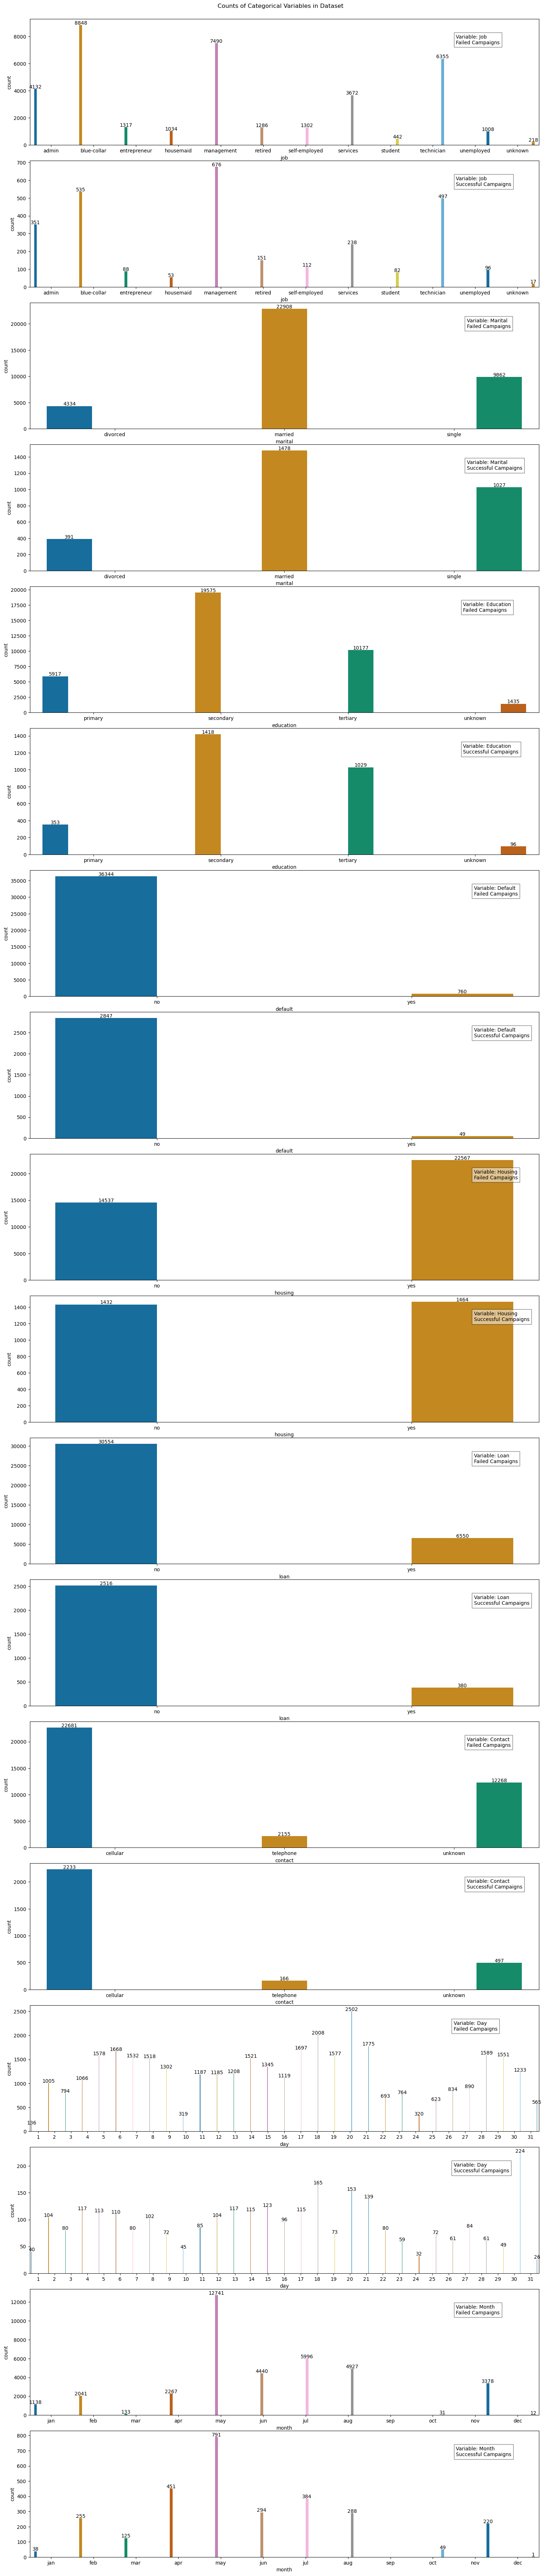

In [64]:
# get total number of plots
num_plots=len(cat_nunique)*2

# create subplots
fig,axes=plt.subplots(num_plots,1,figsize=(15,num_plots*4))
plt.suptitle(t='Counts of Categorical Variables in Dataset',y=.999)
plt.tight_layout()

# flatten axes for easy indexing
axes=axes.flatten()

# plot each column
for i, (col, order) in enumerate(cat_nunique.items()):
#     plot 'no' part
    ax1=sns.countplot(data=df_no,x=col,palette='colorblind', dodge=True, order=order,ax=axes[i*2])
    # ax1.set_title(f'{col.capitalize()} Distribution for Failed Campaigns')
    for p in ax1.patches:
        ax1.annotate(format(p.get_height(), '.0f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center',
                     xytext = (0, 4),
                     textcoords = 'offset points')
    ax1.text(ax1.get_xlim()[1]+(ax1.get_xlim()[1])*(-0.17),
             ax1.get_ylim()[1] - (ax1.get_ylim()[1])*(1/5),
             f'Variable: {col.capitalize()}\nFailed Campaigns', bbox=dict(facecolor='white', alpha=0.5))

    # Plot 'yes' part
    ax2 = sns.countplot(data=df_yes,x=col,palette='colorblind',dodge=True,order=order,ax=axes[i*2 + 1])
    # ax2.set_title(f'{col.capitalize()} Distribution for Successful Campaigns')
    for p in ax2.patches:
        ax2.annotate(format(p.get_height(), '.0f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center',
                     xytext = (0, 4),
                     textcoords = 'offset points')
    ax2.text(ax2.get_xlim()[1]+(ax2.get_xlim()[1])*(-0.17),
             ax2.get_ylim()[1] - (ax2.get_ylim()[1])*(1/5),
             f'Variable: {col.capitalize()}\nSuccessful Campaigns', bbox=dict(facecolor='white', alpha=0.5))

plt.savefig('../figs/2_countcategorical.pdf')
plt.savefig('../figs/2_countcategorical.png')
plt.savefig('../figs/2_countcategorical.jpg')
plt.show()

There is a lot to observe here, but note that although the values differ drastically between successful and failed campaigns, the patterns are similar for most of the features.

Also notable is that there were no calls made to customers in the month of September.

#### Figure 2: Histograms of Continuous Features <a name='fig2'></a>

In [54]:
# make dictionary of just the categorical variables
num_nunique=copy.deepcopy(dict_nunique)
del num_nunique['job']
del num_nunique['marital']
del num_nunique['education']
del num_nunique['default']
del num_nunique['housing']
del num_nunique['loan']
del num_nunique['contact']
del num_nunique['day']
del num_nunique['month']
del num_nunique['y']
num_nunique

{'age': array([58, 44, 33, 47, 35, 28, 42, 43, 41, 29, 53, 57, 51, 45, 60, 56, 32,
        25, 40, 39, 52, 46, 36, 49, 59, 37, 50, 54, 55, 48, 24, 38, 31, 30,
        27, 34, 23, 26, 61, 22, 21, 20, 66, 62, 83, 75, 67, 70, 65, 68, 64,
        69, 72, 71, 19, 76, 85, 63, 90, 82, 73, 74, 78, 80, 94, 79, 77, 86,
        95, 81]),
 'balance': array([  2143,     29,      2, ...,   7222,   3402, 102127]),
 'duration': array([ 261,  151,   76, ..., 1880, 1460, 2219]),
 'campaign': array([ 1,  2,  3,  5,  4,  6,  7,  8,  9, 10, 11, 12, 13, 19, 14, 24, 16,
        32, 18, 22, 15, 17, 25, 21, 43, 51, 63, 41, 26, 28, 55, 50, 38, 23,
        20, 29, 31, 37, 30, 46, 27, 58, 33, 35, 34, 36, 39, 44])}

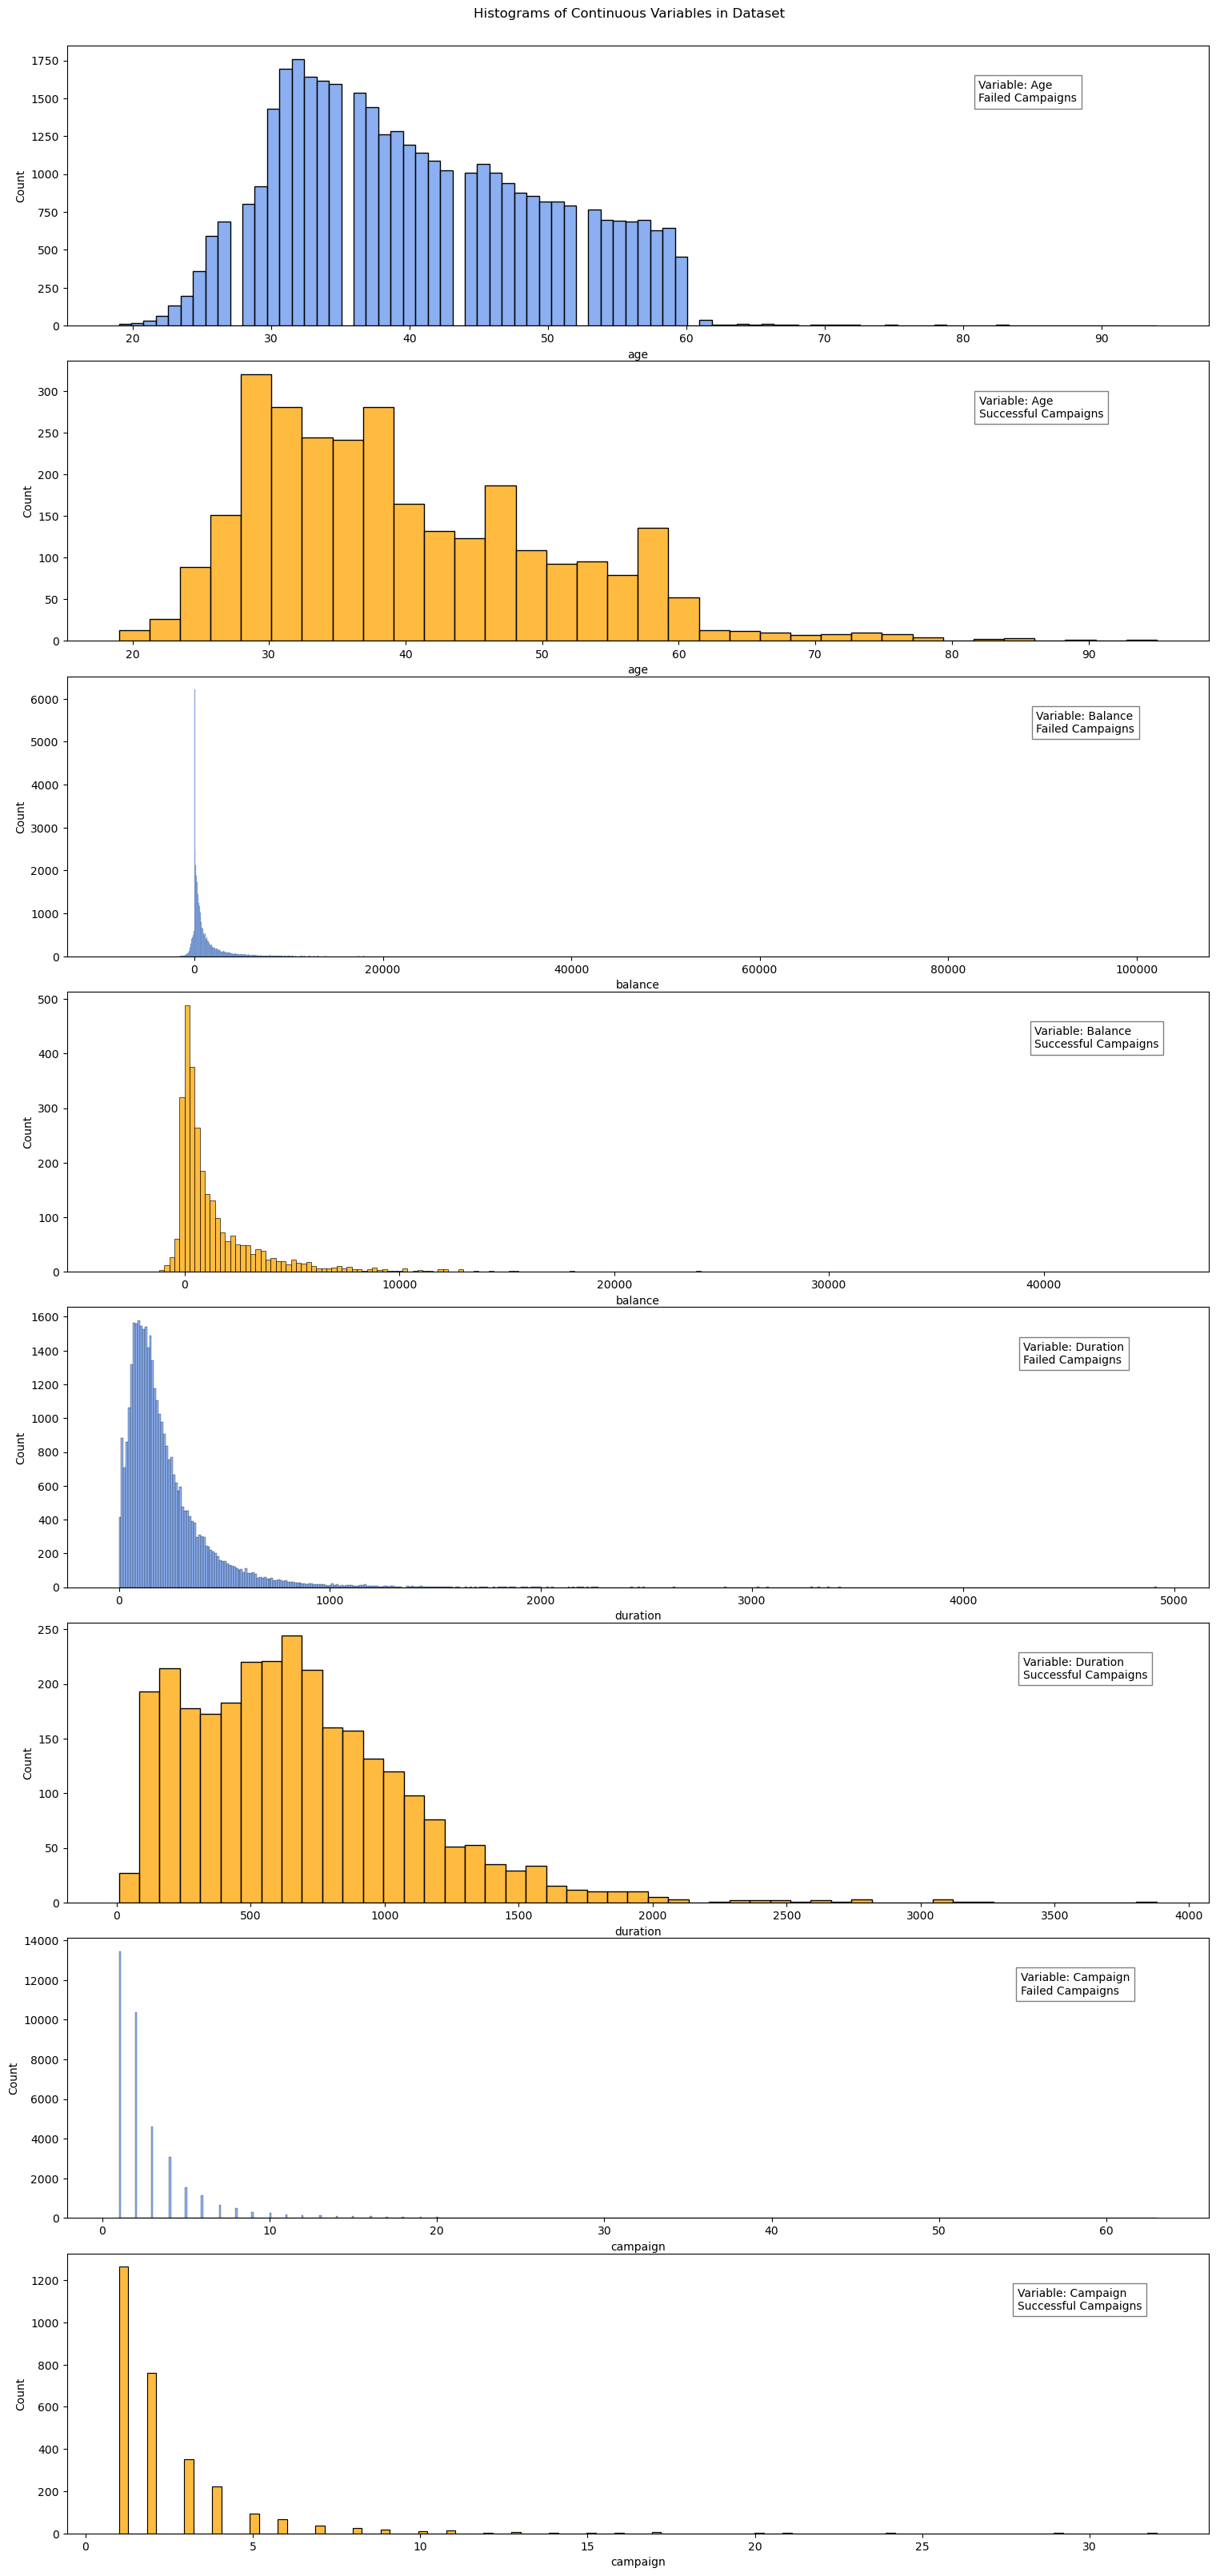

In [55]:
# get total number of plots
num_plots=len(num_nunique)*2

# create subplots
fig,axes=plt.subplots(num_plots,1,figsize=(15,num_plots*4))
plt.suptitle(t='Histograms of Continuous Variables in Dataset',y=.999)
plt.tight_layout()

# flatten axes for easy indexing
axes=axes.flatten()

# plot each column
for i, (col, order) in enumerate(num_nunique.items()):
#     plot 'no' part
    ax1=sns.histplot(data=df_no,x=col,color='cornflowerblue',ax=axes[i*2])
    ax1.text(ax1.get_xlim()[1]+(ax1.get_xlim()[1])*(-0.17),
             ax1.get_ylim()[1] - (ax1.get_ylim()[1])*(1/5),
             f'Variable: {col.capitalize()}\nFailed Campaigns', bbox=dict(facecolor='white', alpha=0.5))

    # Plot 'yes' part
    ax2 = sns.histplot(data=df_yes,x=col,color='orange',ax=axes[i*2 + 1])
    ax2.text(ax2.get_xlim()[1]+(ax2.get_xlim()[1])*(-0.17),
             ax2.get_ylim()[1] - (ax2.get_ylim()[1])*(1/5),
             f'Variable: {col.capitalize()}\nSuccessful Campaigns', bbox=dict(facecolor='white', alpha=0.5))

plt.savefig('../figs/2_histograms.pdf')
plt.savefig('../figs/2_histograms.png')

The patterns between successful and failed campaigns' continuous data are mostly similar, although the X and Y axes are different. The one feature that I see is different is the distribution for duration for successful campaigns is wider than those for failed campaigns. Boxplots may clear this up for us.

#### Figure 3: Boxplots of Continuous Features <a name='fig3'></a>

In [56]:
order

array([ 1,  2,  3,  5,  4,  6,  7,  8,  9, 10, 11, 12, 13, 19, 14, 24, 16,
       32, 18, 22, 15, 17, 25, 21, 43, 51, 63, 41, 26, 28, 55, 50, 38, 23,
       20, 29, 31, 37, 30, 46, 27, 58, 33, 35, 34, 36, 39, 44])

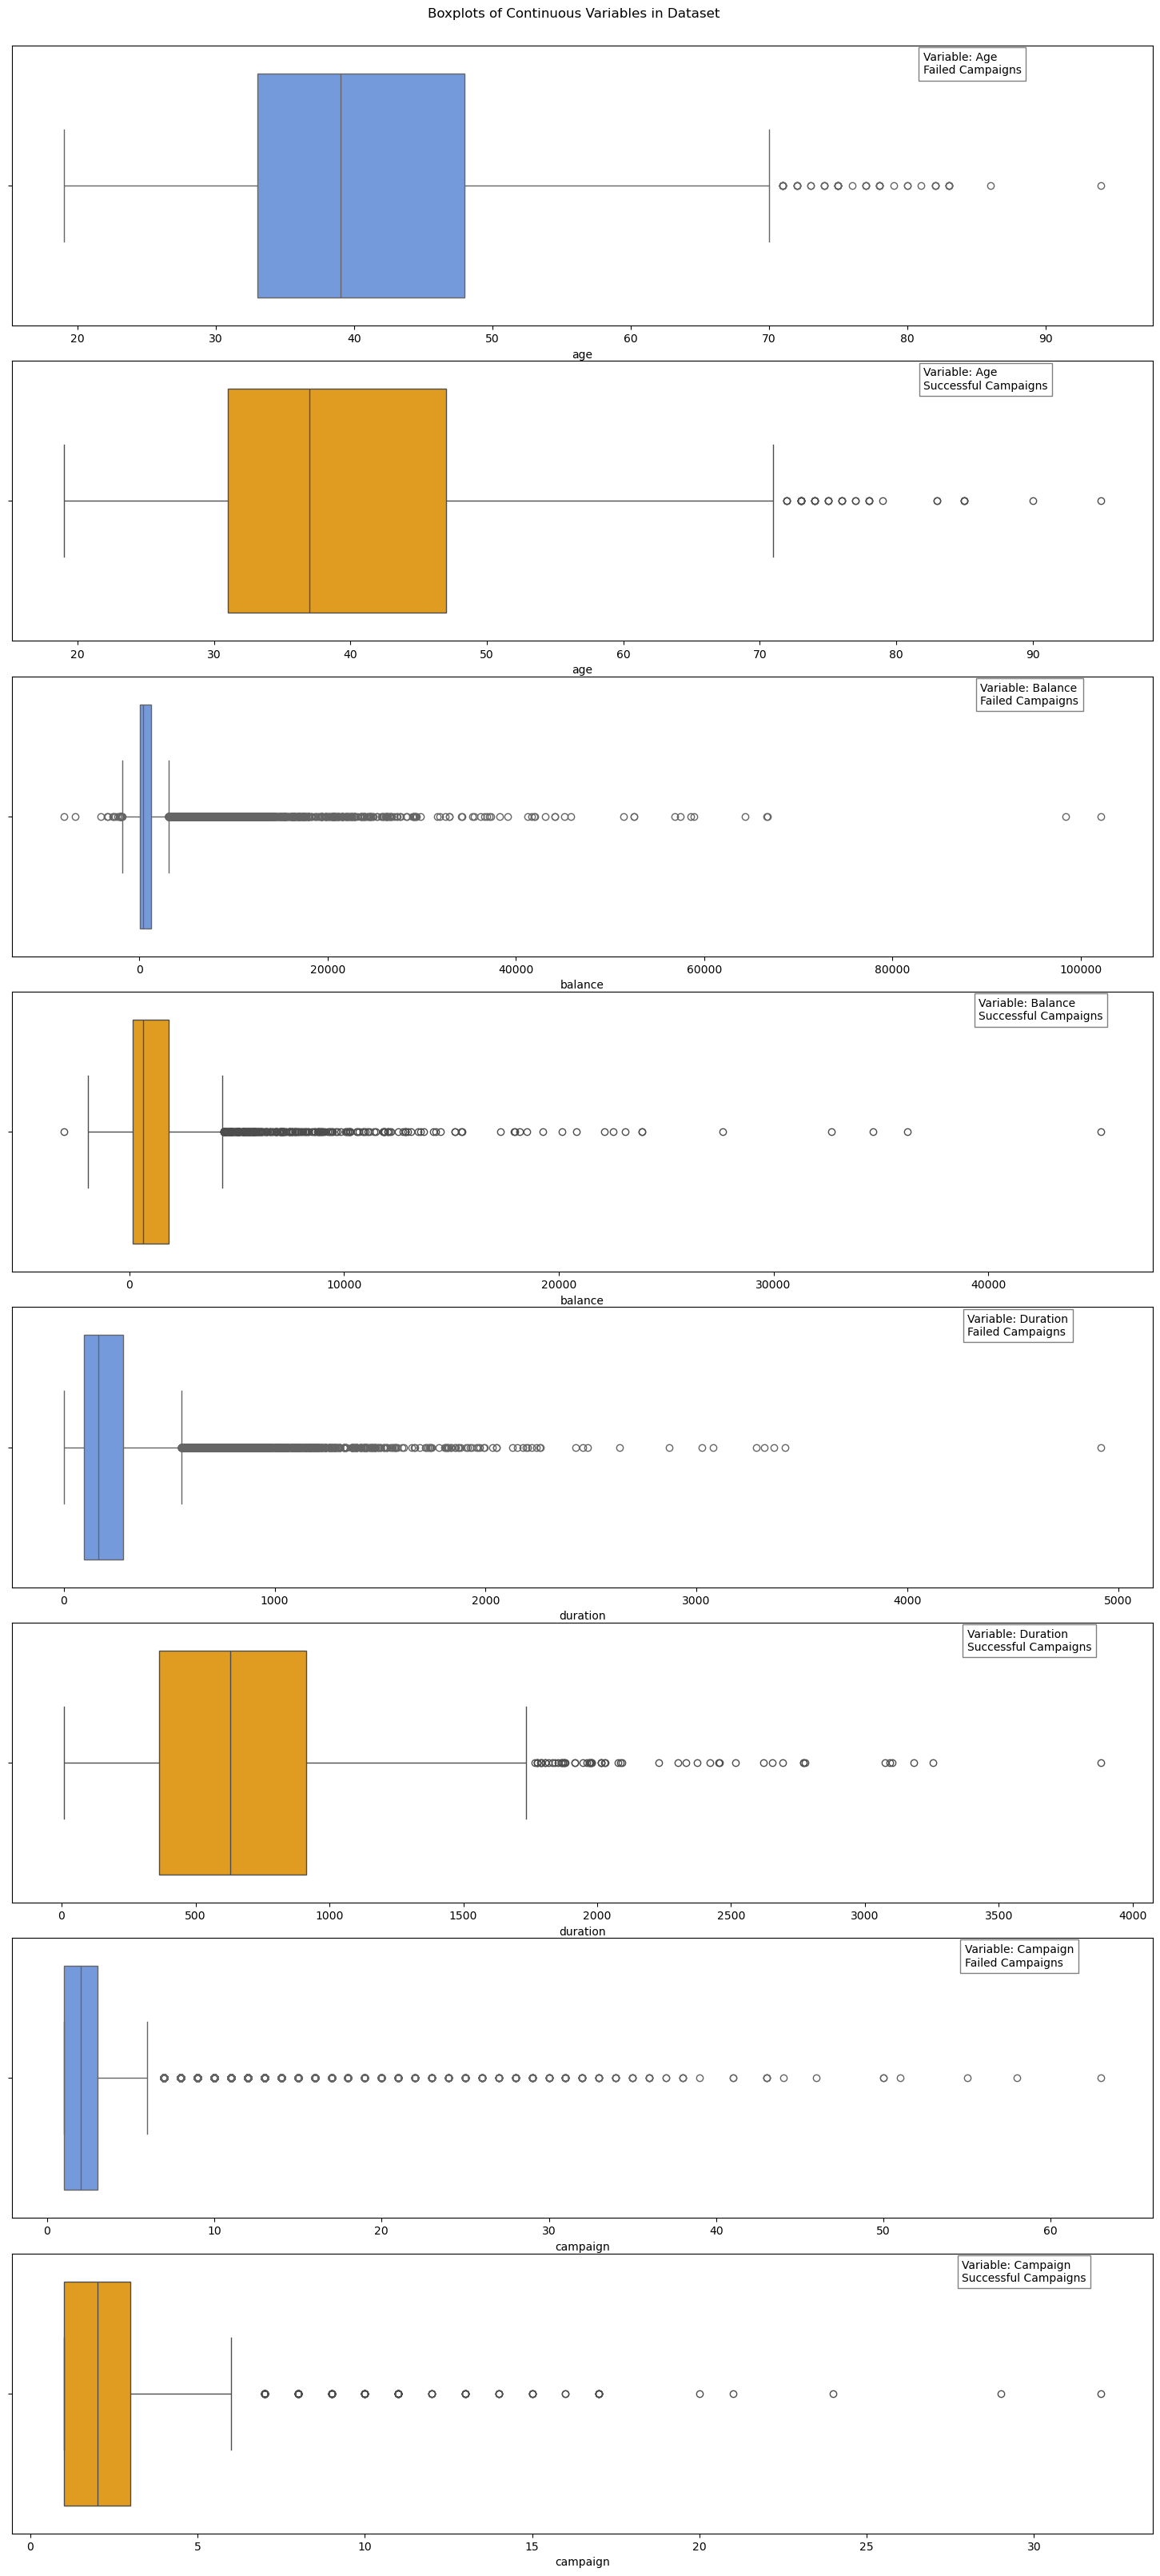

In [65]:
# get total number of plots
num_plots=len(num_nunique)*2

# create subplots
fig,axes=plt.subplots(num_plots,1,figsize=(15,num_plots*4))
plt.suptitle(t='Boxplots of Continuous Variables in Dataset',y=.999)
plt.tight_layout()

# flatten axes for easy indexing
axes=axes.flatten()

# plot each column
for i, (col, order) in enumerate(num_nunique.items()):
#     plot 'no' part
    ax1=sns.boxplot(data=df_no,x=col,color='cornflowerblue',ax=axes[i*2])
    ax1.text(ax1.get_xlim()[1]+(ax1.get_xlim()[1])*(-0.17),
             ax1.get_ylim()[1] - (ax1.get_ylim()[1])*(1/5),
             f'Variable: {col.capitalize()}\nFailed Campaigns', bbox=dict(facecolor='white', alpha=0.5))

    # Plot 'yes' part
    ax2 = sns.boxplot(data=df_yes,x=col,color='orange',ax=axes[i*2 + 1])
    ax2.text(ax2.get_xlim()[1]+(ax2.get_xlim()[1])*(-0.17),
             ax2.get_ylim()[1] - (ax2.get_ylim()[1])*(1/5),
             f'Variable: {col.capitalize()}\nSuccessful Campaigns', bbox=dict(facecolor='white', alpha=0.5))

plt.savefig('../figs/2_boxplots.pdf')
plt.savefig('../figs/2_boxplots.png')
plt.savefig('../figs/2_boxplots.jpg')

Duration does indeed seem different, though recall that this feature is describing how long the last phone call was with the customer. It may not tell us that much.

#### Figure 4: Correlation Matrix of Continuous Features <a name='fig4'></a>

In [58]:
df_num=df[['age','balance','duration','campaign']]

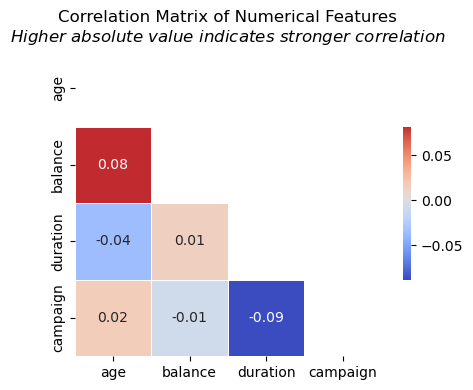

In [59]:
# compute correlation matrix
corr=df_num[['age','balance','duration','campaign']].corr()

# generate mask for the upper triangle
mask=np.triu(np.ones_like(corr, dtype=bool))

# set up matplotlib figure
f,ax = plt.subplots(figsize=(5, 4))

# draw heatmap with the mask and correct aspect ratio
sns.heatmap(corr,mask=mask,cmap='coolwarm',#vmax=1,vmin=-1,
            center=0,
            square=True,linewidths=.5,annot=True,
            fmt='.2f',cbar_kws={"shrink":.5})
plt.title('Correlation Matrix of Numerical Features\n$Higher$ $absolute$ $value$ $indicates$ $stronger$ $correlation$')
plt.tight_layout()

# save fig
plt.savefig('../figs/2_corrmatrix_num.pdf')
plt.savefig('../figs/2_corrmatrix_num.png')

It's good to see that there are no strong correlations with the numerical data. `age`:`balance` makes sense because as you age, you will have had a longer time to accrue more money.

Let's now look at the categorical data now:

#### Figure 5: Correlation Matrix of Categorical Features <a name='fig5'></a>

In [60]:
# make a df of just the categorical values
df_cat=df[['job','marital','education','default','housing','loan','contact','day','month','y']]

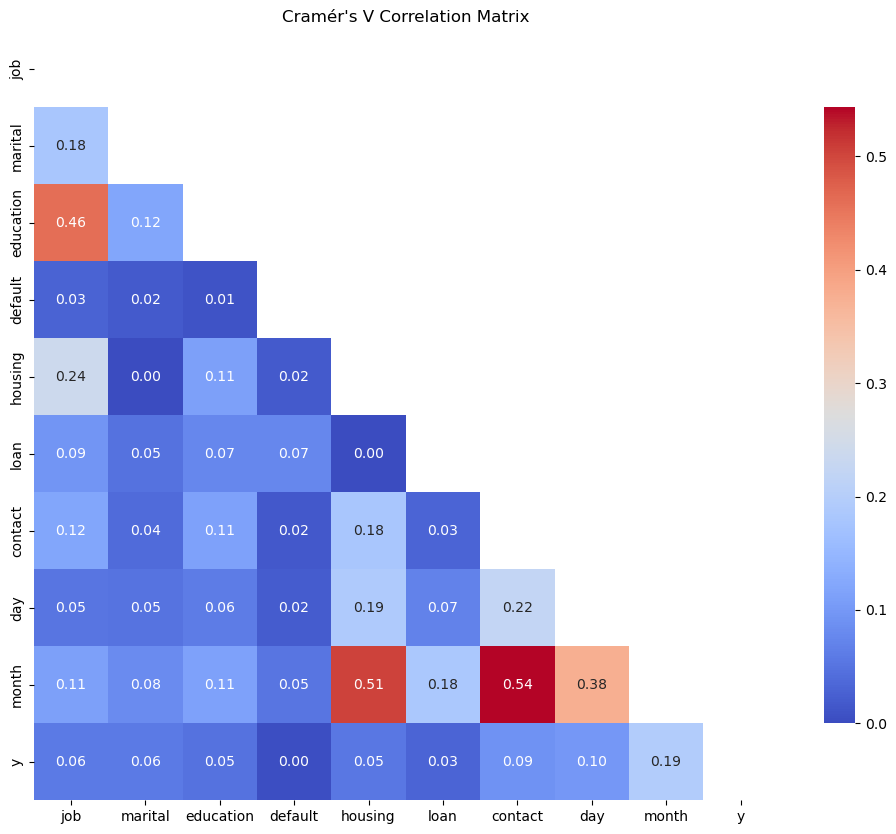

In [61]:
def cramers_v(x, y):
    """Calculate Cramér's V statistic for categorical-categorical association."""
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1)) / (n-1))
    rcorr = r - ((r-1)**2) / (n-1)
    kcorr = k - ((k-1)**2) / (n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

def cramers_v_matrix(df):
    """Compute a matrix of Cramér's V statistics for all pairs of categorical columns in a DataFrame."""
    cols = df.columns
    n = len(cols)
    cv_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            cv_matrix[i, j] = cramers_v(df[cols[i]], df[cols[j]])
    return pd.DataFrame(cv_matrix, index=cols, columns=cols)

# Compute Cramér's V matrix
cv_matrix = cramers_v_matrix(df_cat)

# generate mask for the upper triangle
mask = np.triu(np.ones_like(cv_matrix, dtype=bool))

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cv_matrix, annot=True, cmap='coolwarm', #vmin=-1, vmax=1,
            mask=mask, cbar_kws={"shrink": .8},fmt='.2f')

plt.title("Cramér's V Correlation Matrix")

# save fig
plt.savefig('../figs/2_corrmatrix_categorical.pdf')
plt.savefig('../figs/2_corrmatrix_categorical.png')

plt.show()

This is a great figure. Most correlations are very slight, but there are a few stronger correlations, like `contact`:`month`, `housing`:`month`, `job`:`education`, and `day`:`month`. These correlations mostly make sense.

#### Figure 6: Correlation with Target Variable

In [62]:
df_dummy=pd.get_dummies(df,drop_first=True)

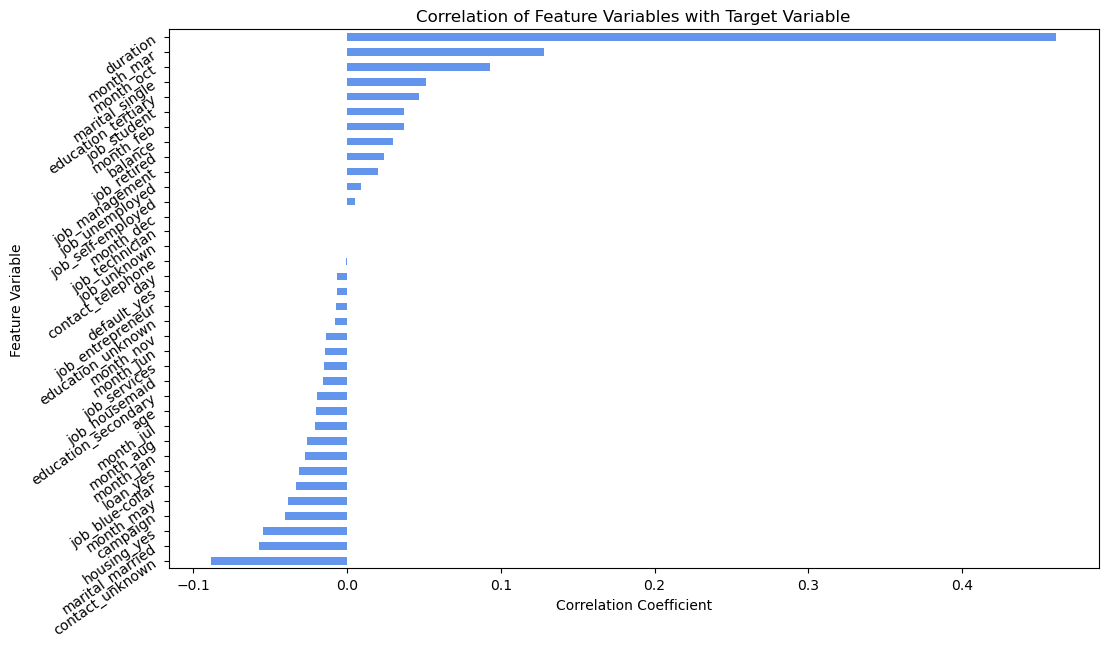

In [66]:
corr=df_dummy.corr()['y_yes'].drop('y_yes').sort_values(ascending=True)

plt.figure(figsize=(12,7))
plt.tight_layout(h_pad=5)

corr.plot(kind='barh',color='cornflowerblue')
plt.title('Correlation of Feature Variables with Target Variable')
plt.ylabel('Feature Variable')
plt.xlabel('Correlation Coefficient')
plt.yticks(rotation=35)

# save fig
plt.savefig('../figs/2_corr_y.pdf')
plt.savefig('../figs/2_corr_y.png')
plt.savefig('../figs/2_corr_y.jpg')

plt.show()

Duration has the highest correlation with the target variable at over 0.4.

#### What about Scatterplots? <a name='scat'></a>

Scatterplots do not seem to give us much insight. The data points are very dispersed and a pattern does not readily emerge:

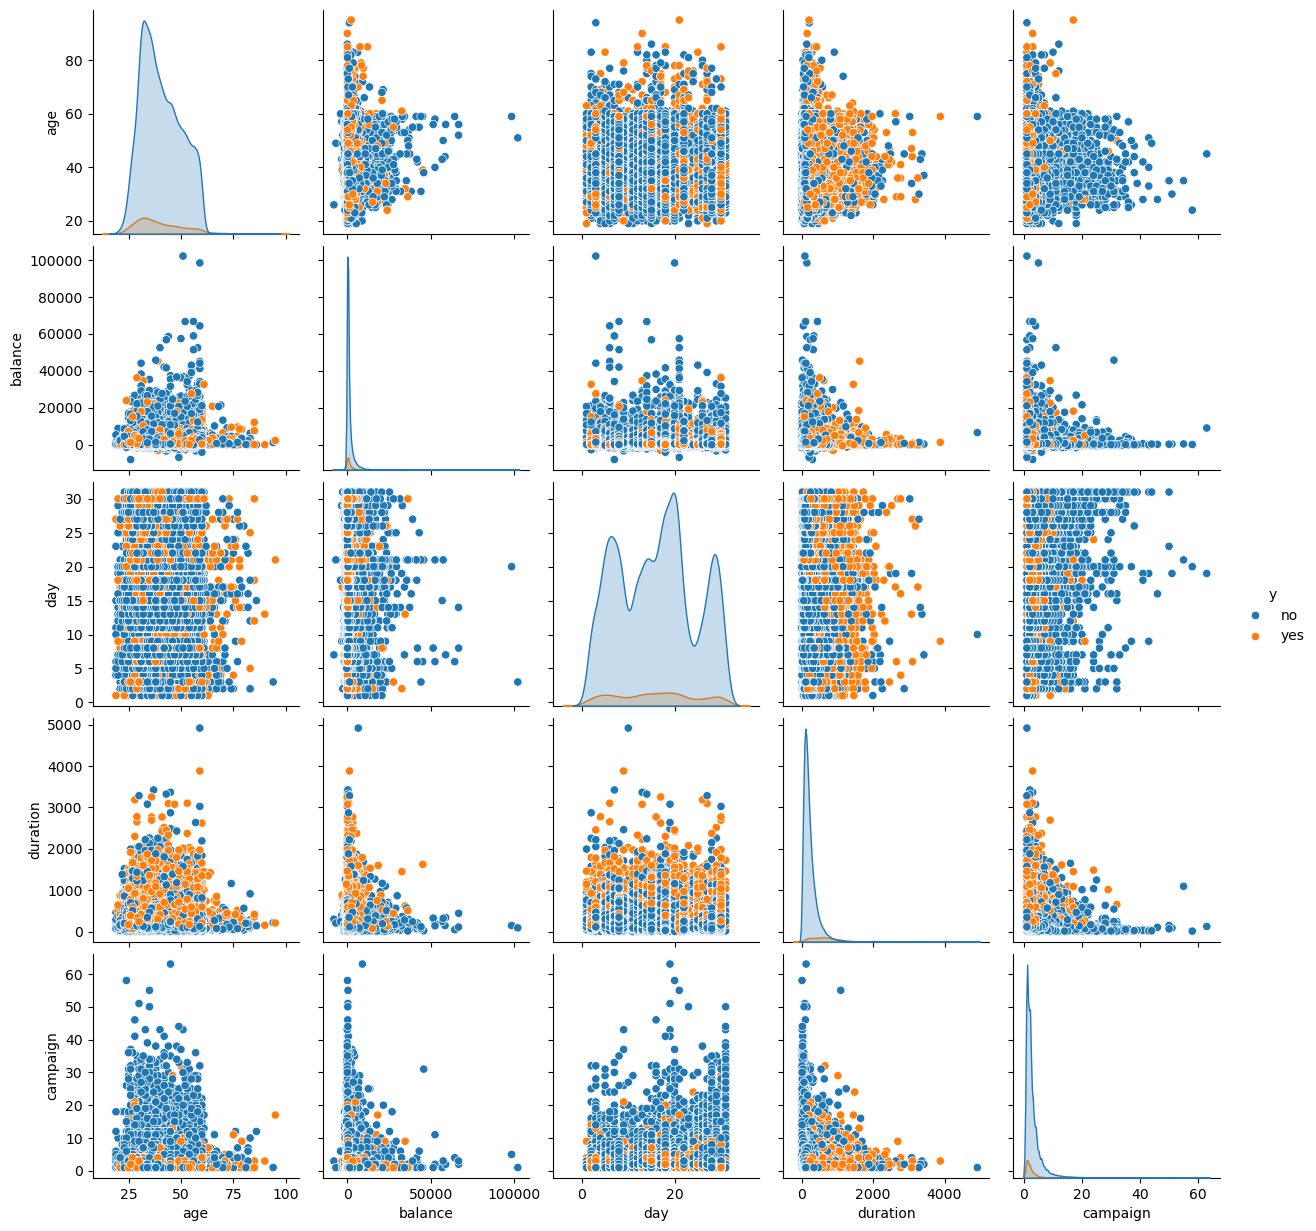

In [67]:
sns.pairplot(data=df,hue='y')

plt.savefig('../figs/2_pairplot.pdf')
plt.savefig('../figs/2_pairplot.png')
plt.savefig('../figs/2_pairplot.jpg')

# Proceed to the [next notebook](project2_modeling.ipynb) to view the modeling efforts.